<a href="https://colab.research.google.com/github/Zahidlab/OCT-classifier/blob/main/OCT_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importing Utils

In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download...")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)
from helper_functions import accuracy_fn

In [ ]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch import nn
from sklearn.datasets import make_circles, make_blobs
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader

In [ ]:
import torch 
print(torch.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

1.13.1+cu116


'cuda'

##Data Download

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Define Transform

In [ ]:
trans = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    
])

In [ ]:
train_dataset = datasets.ImageFolder(root = "/content/drive/MyDrive/Research/Datasets/OCT2017/train",transform = trans)
val_dataset = datasets.ImageFolder(root = "/content/drive/MyDrive/Research/Datasets/OCT2017/val" ,transform = trans)
test_dataset = datasets.ImageFolder(root = "/content/drive/MyDrive/Research/Datasets/OCT2017/test", transform = trans)

In [ ]:
class_names = train_dataset.classes
class_to_idx = train_dataset.class_to_idx
class_to_idx

{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}

##Visualizing Image

In [ ]:
from PIL import Image
picture = Image.open('/content/drive/MyDrive/Research/Datasets/OCT2017/test/CNV/CNV-1016042-1.jpeg')
picture.size

(512, 496)

In [ ]:
img,label = train_dataset[random_idx]
img.shape

torch.Size([1, 224, 224])

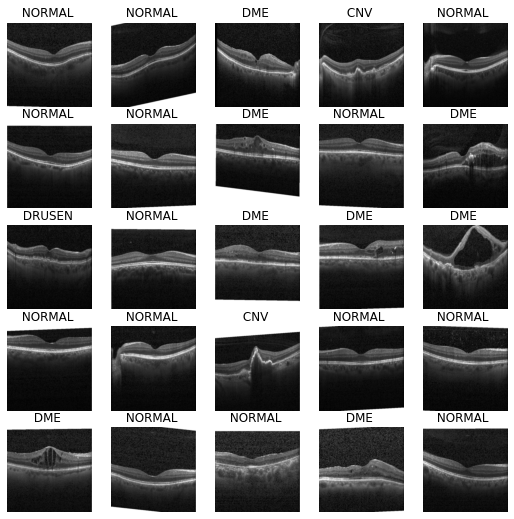

In [ ]:
fig = plt.figure(figsize = (9,9))

rows,cols = 5,5

for i in range(1,rows*cols +1 ):
  random_idx = torch.randint(low = 0, high = len(train_dataset), size = (1,)).item()
  img,label = train_dataset[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap = 'gray')
  plt.title(f" {class_names[label]}  ")
  plt.axis(False)

##Dataloader

In [ ]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True
    
)

test_dataloader = DataLoader(
    dataset = test_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False
    
)

print(f"Length of Train DataLoader {len(train_dataloader)} of {BATCH_SIZE} batch size")
print(f"Length of Test DataLoader {len(test_dataloader)} of {BATCH_SIZE} batch size")

Length of Train DataLoader 1279 of 32 batch size
Length of Test DataLoader 31 of 32 batch size


In [ ]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 224, 224]), torch.Size([32]))

##Model Class

In [ ]:
class OCT(nn.Module):
  def __init__(self, input_shape, output_shape):
    super().__init__()

    self.block_1 = nn.Sequential(
        
        nn.Conv2d(
            in_channels = input_shape, 
            out_channels = 64,
            kernel_size = 3,
            # padding=1,
            # stride=1,
        ),
        nn.ReLU(),

        nn.MaxPool2d(
            kernel_size = 2,
            # stride=2,
        ),

        # 
        nn.Conv2d(
            in_channels = 64, 
            out_channels = 128,
            kernel_size = 3,
            # padding=1,
            # stride=1,

        ),

        nn.ReLU(),

        nn.MaxPool2d(
            kernel_size = 2,
            # stride=2,
        ),
        # 

        nn.Conv2d(
            in_channels = 128, 
            out_channels = 256,
            kernel_size = 3,
            # padding=1,
            # stride=1,

        ),

        nn.ReLU(),

        nn.MaxPool2d(
            kernel_size = 2,
            # stride=2,
        ),
        # 

        nn.Conv2d(
            in_channels = 256, 
            out_channels = 512,
            kernel_size = 3,
            # padding=1,
            # stride=1,

        ),

        nn.ReLU(),

        nn.MaxPool2d(
            kernel_size = 2,
            # stride=2,
        ),


    )


    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = 512*12*12, out_features = 4096),
        nn.Linear(in_features = 4096, out_features = output_shape)

    )
  
  def forward(self, x):
    x = self.block_1(x)
    # x = self.block_2(x)
    # print(x.shape)
    x = self.classifier(x)

    return x





In [ ]:
oct_model = OCT(input_shape= 1,
                output_shape = 4,)

In [ ]:
demo_x = torch.rand([1,1,224,224,])
oct_model(demo_x)

tensor([[ 0.0030, -0.0168, -0.0209,  0.0009]], grad_fn=<AddmmBackward0>)

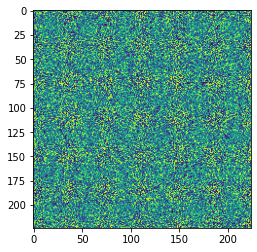

In [ ]:
plt.imshow(demo_x[0].squeeze())

##Loss & Optimizer

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = oct_model.parameters(), 
                            lr = 0.1)


##Test Function

In [ ]:
def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader, 
               loss_fn : torch.nn.Module,

              accuracy_fn,
              device = device
               ):
  
  test_loss, test_acc = 0,0
  torch.manual_seed(42)
  # Evaluation Mode
  model.eval()
  with torch.inference_mode():
    for X,y in data_loader:
      test_pred = model(X)
     
      test_acc += accuracy_score(y, test_pred.argmax(dim = 1))

      test_loss += loss_fn(test_pred, y)
    
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
 

  print(f"Testing Loss:  {test_loss:.4f} | Testing Accuracy: {test_acc:.4f}\n")



In [ ]:
def evaluate_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader, 
               loss_fn : torch.nn.Module,

              accuracy_fn,
              device = device
               ):
  
  test_loss, test_acc = 0,0
  torch.manual_seed(42)
  # Evaluation Mode
  model.eval()
  with torch.inference_mode():
    for X,y in data_loader:
      y_pred = model(X)
     
      test_acc += accuracy_score(y, y_pred.argmax(dim = 1))

      test_loss += loss_fn(y_pred, y)
    
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
 

  return {
      "model": model.__class__.__name__,
      "loss": test_loss,
      "acc": test_acc,
  }

##Train Function

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device = device 
               ):
  
  train_loss, train_acc = 0,0
  torch.manual_seed(42)
  #Training Mode
  model.train()
  
  for batch, (X,y) in enumerate(data_loader):


    #forward Pass
    y_pred = model(X)

    #Calculate Loss & Accumulate
    loss  = loss_fn(y_pred, y)
    train_loss += loss

    #Calculate Accuracy & Accumulate
    acc = accuracy_score(y, y_pred.argmax(dim = 1))
    train_acc+= acc

    #Zeroing Optimizer
    optimizer.zero_grad()

    #Backward Pass
    loss.backward()

    #Optimizer Pass
    optimizer.step()

  #Calculating Average Accuracy & Loss
  train_loss/=len(data_loader)
  train_acc/=len(data_loader)

  print(f"Training Loss: {train_loss:.4f} | Training Accuracy: {train_acc:.4f}\n")



In [ ]:
# from helper_functions import accuracy_fn
# loss_fn = nn.CrossEntropyLoss() # measure how wrong our model is
# optimizer = torch.optim.SGD(params=Classifier_Model.parameters(), # tries to update our model's parameters to reduce the loss 
#                             lr=0.1)

##Train - Test

In [ ]:
from timeit import default_timer as timer
from tqdm.auto import tqdm
start = timer()
torch.manual_seed(42)

EPOCHS = 10

for epoch in tqdm(range(EPOCHS)):
  print(f"Epoch: {epoch} \n--------")


  train_step(model=oct_model,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn,
             optimizer=optimizer,
             )
  
  test_step(model = oct_model,
            data_loader = test_dataloader,
            loss_fn = loss_fn,
            accuracy_fn=accuracy_fn,
            )
  


total_time = timer() - start

print(total_time)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 
--------


In [ ]:
result = evaluate_model(model = oct_model,
             data_loader = test_dataloader,
             loss_fn = loss_fn,
             accuracy_fn = accuracy_fn)

In [ ]:
result

In [ ]:
import random
test_images = []
test_labels = []

for image, label in random.sample(list(test_data), k = 16):
  test_images.append(image)
  test_labels.append(label)


In [ ]:
def visualize_test_images(test_data, model:torch.nn.Module, count = 9):

  ### Sampling
  test_images = []
  test_labels = []

  for image, label in random.sample(list(test_data), k = count):
    test_images.append(image)
    test_labels.append(label)

  ### Making Prediction
  model.eval()
  pred_labels = []
  with torch.inference_mode():
    for image in test_images:
      # print(image.shape)
      image = image.unsqueeze(dim=0)
      # print(image.shape)

      pred_logits = model(image)
      pred_logits = pred_logits.squeeze()

      pred_proba = torch.softmax(pred_logits, dim=0)

      pred_label = pred_proba.argmax()
      pred_labels.append(pred_label.item())
    
      # print(f"Logits Shape -> {pred_logits.shape} | Logits -> {pred_logits}")
      # print(f"Proba Shape -> {pred_proba.shape} | Proba -> {pred_proba}")
      # print(f"Label Shape -> {pred_label.shape} | Label -> {pred_label}")

  


  ### Visualize
  plt.figure(figsize = (9,9))
  rows = 3
  cols = 3

  for i,sample in enumerate(test_images):
    plt.subplot(rows, cols, i+1)

    plt.imshow(sample.squeeze(), cmap = 'gray')

    pred_label = class_names[pred_labels[i]]
    real_label = class_names[test_labels[i]]
    
    if pred_label == real_label:
      plt.title(f"Real {real_label} || Pred: {pred_label}",fontsize=10, c = 'g')
    else:
      plt.title(f"Real {real_label} || Pred: {pred_label}",fontsize=10, c = 'r')

    plt.axis(False)




In [ ]:
visualize_test_images(test_data=test_data, model=cnn_model, count = 9 )



In [ ]:
test_images[0].unsqueeze(dim=0).shape